2.7.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 5, 81, 144)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 21, 36)   3936        ['img_input[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 11, 18)   8224        ['conv2d_1[0][0]']               
                                                                                                  
 data_input (InputLay

BACKING UP IN 2 SECONDS


return v. episode


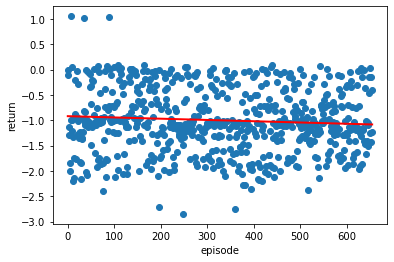


td error v. frame


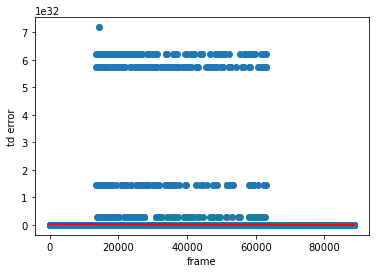


performance (J of theta) v. frame


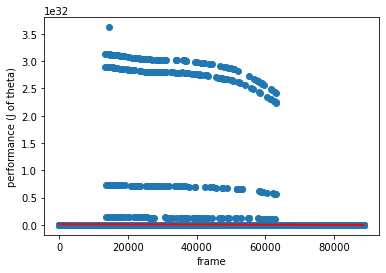

ValueError: cannot reshape array of size 0 into shape (81,144)

In [1]:
# Import packages.
import tensorflow as tf             # Tensorflow.
import numpy as np                  # I chose NumPy instead of Pandas because it uses less RAM
import time, socket, datetime
import matplotlib.pyplot as plt

import cv2

from Scripts import config as cfg
from Scripts import Agent_CNN as agent

print(tf.__version__)
# This code allows for the GPU to be utilized properly.
tf.get_logger().setLevel('ERROR')
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

print(physical_devices)

def send(client, msg):
    '''Send data to game, including confirmation response'''

    client.send(str(msg).encode())
    # print("msg sent")
    client.recv(1024)
    # print("msg acknowledged")

def recv(client):
    '''Receive data to game, including confirmation response'''

    data = client.recv(1024).decode()
    # print("msg received")
    client.send("acknowledge".encode())
    # print("msg acknowledged")
    return data

def recvBytes(client, bufferSize):
    data = client.recv(bufferSize)
    client.send("acknowledge".encode())
    return list(data)

def invData(data):
    '''Invert data to convert from perspective of plane 1 to plane 2.
       Does NOT take np arrays'''
    length = int(len(data) / 2 )
    return data[length:] + data[:length]

def plot(data, x, y):
    '''Plot statistics.'''
    
    print(y + " v. " + x)

    indices = np.arange(len(data))
    plt.scatter(indices, data)

    a, b = np.polyfit(indices, data, 1)
    plt.plot(indices, a*indices+b, color="red", linewidth="2")

    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
    print()

# mu = 0.5
# sigma = 0.16

# dist = np.random.default_rng().standard_normal(size=10000) * sigma + mu
# count, bins, ignored = plt.hist(dist, 30, density=True)
# plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
#                np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
#          linewidth=2, color='r')
# plt.show()

# ==================== Training ==================== #

# Time in FRAMES
time_since_save = 0
agent = agent.agent()

while True:
    # Do stuff per episode
    # The server/client connection is established at the start of EVERY episode
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as server:
        # Bind to port
        server.bind((cfg.HOST, cfg.PORT))

        # Connect to game
        server.listen(1)
        client, address = server.accept()

        '''B'''
        # Receive the first state from game

        # Receive screen
        cam_1 = np.reshape(np.array(recvBytes(client, cfg.width * cfg.height), dtype=cfg.cam_memtype), (cfg.height, cfg.width))
        # print("Received CAM1")
        cam_2 = np.reshape(np.array(recvBytes(client, cfg.width * cfg.height), dtype=cfg.cam_memtype), (cfg.height, cfg.width))
        # print("Received CAM2")

        num_messages = int(recv(client))
        # print("Received DATA1 len")
        data_1 = np.ndarray(num_messages, dtype=np.float32)
        for x in range(num_messages):
            data_1[x] = recv(client)
        # print("Received all of DATA1")
        num_messages = int(recv(client))
        # print("Received DATA2 len")
        data_2 = np.ndarray(num_messages, dtype=np.float32)
        for x in range(num_messages):
            data_2[x] = recv(client)
        # print("Received all of DATA2")

        # pop death data
        data_1 = data_1[:-1]
        data_2 = data_2[:-1]

        # plt.imshow(cam_1, cmap="gray", vmin=0, vmax=255)
        # plt.show()

        # Initialize agents with the first state from the game
        agent.init_phi((cam_1, data_1), (cam_2, data_2))


        # data collection
        R = 0
        it = 0


        # Episode loop
        while True:
            '''A
            Send predictions to game'''
            # Get prediction input values from model
            actions1, means, value1 = agent.get_actions(1)
            actions2, _, value2 = agent.get_actions(2)
            num_messages = cfg.num_actions

            # get pitch mean value for first state
            if it == 0:
                it = 1
                agent.stats["pitch_mean"].append(means[0])
                # print(means[0])

            # Clip predictions from -1 to +1 for game input
            actions1 = np.clip(actions1, -1, 1)
            actions2 = np.clip(actions2, -1, 1)
            
            actions1 = np.concatenate((actions1, value1))
            actions2 = np.concatenate((actions2, value2))
            num_messages = 5

            # Send predictions of plane 1 to game
            send(client, num_messages)
            # print(f"Sent ACTION1 len ({num_messages}), sending ACTION1:")
            for x in range(num_messages):
                send(client, actions1[x])
                # print(actions1[x])
            # Send predictions of plane 2 to game
            send(client, num_messages)
            # print(f"Sent ACTION2 len ({num_messages}), sending ACTION2:")
            for x in range(num_messages):
                send(client, actions2[x])
                # print(actions2[x])


            '''B
            Receive update from game'''
            # Receive screen
            cam_1 = np.reshape(np.array(recvBytes(client, cfg.width * cfg.height), dtype=cfg.cam_memtype), (cfg.height, cfg.width))
            # print("Received CAM1")
            cam_2 = np.reshape(np.array(recvBytes(client, cfg.width * cfg.height), dtype=cfg.cam_memtype), (cfg.height, cfg.width))
            # print("Received CAM2")
            
            
            # plt.imshow(cam_1, cmap="gray", vmin=0, vmax=255)
            # plt.show()

            num_messages = int(recv(client))
            # print(f"Received DATA1 len ({num_messages}), receiving DATA1:")
            data_1 = np.ndarray(num_messages, dtype=np.float32)
            for x in range(num_messages):
                data_1[x] = recv(client)
                # print(data_1[x])
            num_messages = int(recv(client))
            # print(f"Received DATA2 len ({num_messages}), receiving DATA2:")
            data_2 = np.ndarray(num_messages, dtype=np.float32)
            for x in range(num_messages):
                data_2[x] = recv(client)
                # print(data_2[x])

            '''Process data received from game'''

            # pop death data
            P1_alive = data_1[-1]
            P2_alive = data_2[-1]
            data_1 = data_1[:-1]
            data_2 = data_2[:-1]
            P1_nose_angle = data_1[-1]
            P2_nose_angle = data_2[-1]

            reward_range = cfg.max_reward_angle - cfg.min_reward_angle
            if P1_nose_angle < cfg.angle_threshold:
                P1_reward = (1 - P1_nose_angle / cfg.angle_threshold) * reward_range + cfg.min_reward_angle
            else:
                P1_reward = cfg.min_reward_angle
            if P2_nose_angle < cfg.angle_threshold:
                P2_reward = (1 - P2_nose_angle / cfg.angle_threshold) * reward_range + cfg.min_reward_angle
            else:
                P2_reward = cfg.min_reward_angle

            # Check if either plane is dead via OOB
            if P1_alive == 1:
                P1_reward = cfg.reward_death
            if P2_alive == 1:
                P2_reward = cfg.reward_death
            # Check if either plane is dead via shooting
            if P1_alive == 2:
                P1_reward = cfg.reward_death
                P2_reward = cfg.reward_kill
                print(f"{datetime.datetime.now()}: Plane 2 killed plane 1")
            if P2_alive == 2:
                P2_reward = cfg.reward_death
                P1_reward = cfg.reward_kill
                print(f"{datetime.datetime.now()}: Plane 1 killed plane 2")

            '''Do agent stuff'''
            agent.reward_transition(1, P1_reward, (cam_1, data_1))
            agent.reward_transition(2, P2_reward, (cam_2, data_2))
            agent.learn()
            agent.train_data["frames_played"] += 1


            R += P1_reward


            if P1_alive > 0 or P2_alive > 0:

                agent.stats["return"].append(R)


                # Save model if autosave period is reached
                if time_since_save % cfg.autosave_period == 0:
                    print()

                    print("SAVING IN 2 SECONDS")
                    time.sleep(2)
                    agent.save_all(cfg.save_path)

                    print("BACKING UP IN 2 SECONDS")
                    time.sleep(2)
                    agent.save_all(cfg.backup_path)

                    plot(agent.stats["return"], "episode", "return")
                    plot(agent.stats["td_error"], "frame", "td error")
                    plot(agent.stats["performance_measure"], "frame", "performance (J of theta)")

                    print()
                    print()
                
                send(client, "time to restart")
                client.shutdown(socket.SHUT_RDWR)
                client.close()
                time_since_save += 1
                break


In [25]:
import tensorflow as tf
import numpy as np

with tf.GradientTape(persistent=True) as tape:
    x = tf.reshape(tf.range(0., 9.), (3, 3))
    w = tf.Variable((0., 1., 2.))
    y = x * w
    z = tf.reduce_sum(y)
    # y = tf.where(tf.math.less(y, 0.001), tf.ones_like(y), y)

# print(x.numpy())
print(y.numpy())
print(tape.gradient(y, w).numpy())
print(tape.gradient(z, w).numpy())

[[ 0.  1.  4.]
 [ 0.  4. 10.]
 [ 0.  7. 16.]]
[ 9. 12. 15.]
[ 9. 12. 15.]


In [3]:
import math
a = (1 * 1 - math.pow(1, 2) / 2) / math.pow((1.8856641 * math.pow(10, -17)), 2)
print(a)
                                                            

1.4061813659459742e+33


In [6]:
from tensorflow.keras import backend as K
import tensorflow as tf

def offset_sigmoid(x):
    return K.sigmoid(x) * 0.99 + 0.01

a = tf.Variable((1., 0, -9999999999999999999999999999))

print(offset_sigmoid(a))

tf.Tensor([0.73374796 0.505      0.01      ], shape=(3,), dtype=float32)


In [5]:
import numpy as np

dtype = np.dtype([("a", np.float32), ("y", np.int32)])
a = np.zeros((2, 3), dtype=dtype)
print(a)

[[(0., 0) (0., 0) (0., 0)]
 [(0., 0) (0., 0) (0., 0)]]
